In [1]:
import sys
sys.path.append("../code/chain-diagnostics/")
sys.path.insert(0, "../code/hod-scripting-utils")
sys.path.insert(0, "../code/halotools-utils/")
sys.path.insert(0, "../code/jackknife-tools/")
from cosmosis_utils import *
from halotools_utils import *
from chain_diagnostics import *
from jack_tools import *
import os

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

from chain_diagnostics import plot_chain_diagnostics
from getdist import MCSamples, plots

from cosmosis.runtime.config import Inifile
from cosmosis.runtime.pipeline import LikelihoodPipeline, Pipeline

%matplotlib inline

In [2]:
!head ../data/xi-mcmc-chains/hod_synt5.emcee1.out.txt

/bin/bash: /home/pedro/miniconda3/envs/monografia/lib/libtinfo.so.6: no version information available (required by /bin/bash)
#hod_parameters--sigmam	hod_parameters--massmin	hod_parameters--alpha	hod_parameters--mass0	hod_parameters--mass1	post
#sampler=emcee
#n_varied=5
#module_0=camb #name from ini file
#module_1=hmc #name from ini file
#walkers=48
#samples=20000
#nsteps=10
#random_start=False
#start_points=


In [3]:
data_dir     = "../data/xi-mcmc-chains/"
plot_dir     = "../plots/xi-mcmc-chains/"
chain_fname  = os.path.join(data_dir, "hod_synt5.emcee1.out.txt")
chain_data   = np.loadtxt(chain_fname)


fig      = plt.figure(figsize=(6.6, 4.4))
axs      = fig.subplots(5, 3)

names    = ["sigmam", "massmin", "alpha", "mass0", "mass1"]
labels   = [r"$\sigma_{\log\:M}$", r"$\log\: M_{min}$", r"$\alpha$", r"$\log\: M_0$", r"$\log\: M_1$"]
nwalkers = 48


fig, axs = plot_chain_diagnostics(samples=chain_data[:,:-1].T, labels=labels,
                                  nwalkers=nwalkers, fig=fig, axs=axs)

fig.tight_layout()

for ax in axs.flatten():
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.tick_params(axis='both', which='minor', labelsize=7)

plt.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.1)

fig.savefig(os.path.join(plot_dir, "chain_diagnostics_xi_mcmc_chain.pdf"), dpi=600)
fig.savefig(os.path.join(plot_dir, "chain_diagnostics_xi_mcmc_chain.png"), dpi=100)

/home/pedro/miniconda3/envs/monografia/lib/python3.7/site-packages/emcee/autocorr.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  acf = np.fft.ifft(f * np.conjugate(f), axis=axis)[m].real


Emcee integrated autocorrelation time for par  $\sigma_{\log\:M}$  : 215.98540077715091
Emcee integrated autocorrelation time for par  $\log\: M_{min}$  : 3.8892317599048223
Emcee integrated autocorrelation time for par  $\alpha$  : 1.0366656381895574
Emcee integrated autocorrelation time for par  $\log\: M_0$  : 1.3472154303478316
Emcee integrated autocorrelation time for par  $\log\: M_1$  : 2.6374125652748885


In [4]:
true_values = {'sigmam':   0.43,
               'massmin': 12.00,
               'alpha':    1.15,
               'mass0':   11.02,
               'mass1':   13.01}

bestfit = {
    "sigmam": 0.105593,
    "massmin": 11.8121,
    "alpha": 1.27416,
    "mass0": 8.26221,
    "mass1": 13.1263,
}

In [5]:
mc_samples = MCSamples(samples=chain_data[:,:-1], 
                       names=names, labels=map(lambda x: x.replace("$", ""), labels), 
                       loglikes=np.log(-chain_data[:,-1]), ignore_rows=0.5,
                       ranges={'sigmam':   (0.01, 0.6),
                               'massmin': (11., 12.4),
                               'alpha':     (0.9, 1.4),
                               'mass0':     (10., 13.),
                               'mass1':   (11., 13.2),
                              },
                        settings={"smooth_scale_2D": 0.4,
                                  "smooth_scale_1D": 0.3,
                                  "fine_bins_2D": 100,
                                  "fine_bins": 100},
                        label="Amostra sintética (halotools, Bolshoi BDM halos)"
                      )

Removed 0.5 as burn in


In [6]:
def one_sigma_minmax(mc_samples, num):
    par = mc_samples.getMargeStats().parsWithNames(names[num])[0]
    try:
        return par.limits[0].lower, par.limits[0].upper
    except AttributeError:
        return np.nan, np.nan

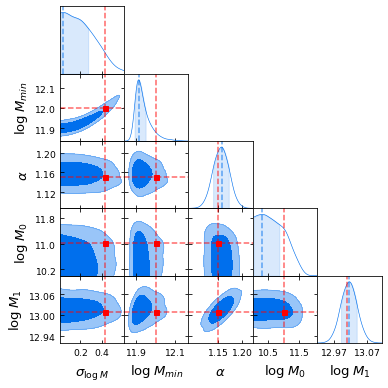

In [7]:
g = plots.getSubplotPlotter()
g.settings.alpha_filled_add     = 0.6
g.settings.fig_width_inch       = 5.5
g.settings.axes_fontsize        = 14
g.settings.axes_labelsize       = 18

g.triangle_plot([mc_samples,], filled=True,
                title_limit=0,
                contour_colors = [g.settings.solid_colors[0]],
               )

for i, key in enumerate(true_values.keys()):
    for j, other_key in enumerate(true_values.keys()):
        if j > i:
            continue
        ax = g.subplots[i,j]
        ax.axvline(true_values[other_key], color="red", ls= "--", alpha=0.6)
        if j == i:
            x, y = ax.lines[0].get_data()
            c    = ax.lines[0].get_color()
            xmin, xmax = one_sigma_minmax(mc_samples, i)
            ax.fill_between(x, 0, y, where=((x > xmin) & (x < xmax)), color=c, alpha=0.15)
            ax.axvline(x[y.argmax()], color=c, ls="--", alpha=0.6)
            ax.set_title(ax.get_title(), fontsize=11)
            continue
        ax.axhline(true_values[key], color='red', ls='--', alpha=0.6)
        ax.plot(true_values[other_key], true_values[key], "s", ms=5, color="r")

g.fig.savefig(os.path.join(plot_dir, "corner_plot_xi_mcmc_chain.pdf"), dpi=600)
g.fig.savefig(os.path.join(plot_dir, "corner_plot_xi_mcmc_chain.png"), dpi=100)

In [14]:
print(mc_samples.getTable(limit=2).tableTex())

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$\sigma_{\log\:M}$} & $< 0.472                   $\\

{\boldmath$\log\: M_{min} $} & $11.935^{+0.089}_{-0.064}  $\\

{\boldmath$\alpha         $} & $1.156^{+0.034}_{-0.034}   $\\

{\boldmath$\log\: M_0     $} & $< 11.4                    $\\

{\boldmath$\log\: M_1     $} & $13.015^{+0.050}_{-0.050}  $\\
\hline
\end{tabular}


In [8]:
hod_data_path    = data_dir
default_pipeline = os.path.join(data_dir, "pipeline.ini")
hod_path = os.path.abspath("../code/hod")
camb_path = "${HOME}/.local/bin/CAMB-0.1.6.1/camb"

default_env_vars = {
    "HOD_PATH": hod_path,
    "HOD_DATA_PATH": hod_data_path,
    "CAMB_PATH": camb_path,
}
override_dict = {
    #"save_xi": True,
}
hodpars_t = {                                                                                                                                                                                                                    
           "sigmam": 0.43,                                                                                                                                                                                                     
           "massmin": 11.50,                                                                                                                                                                                                   
           "alpha": 1.15,                                                                                                                                                                                                      
           "mass0": 11.02,                                                                                                                                                                                                     
           "mass1": 13.01,                                                                                                                                                                                                     
           "fcentral": 0.5                                                                                                                                                                                                     
          }

hodpars_o = {                                                                                                                                                                                                                    
           "sigmam": 0.455852,
           "massmin": 11.6668,
           "alpha": 1.22387,
           "mass0": 11.1297,
           "mass1": 13.154,
           "fcentral": 0.5                                                                                                                                                                                                     
          }


In [9]:
r_t, xi_t, xi_t_1h, xi_t_2h = calculate_xi(hodpars_t, default_pipeline, default_env_vars, override_dict)
r_o, xi_o, xi_o_1h, xi_o_2h = calculate_xi(hodpars_o, default_pipeline, default_env_vars, override_dict)

mask = r_t < 1e2
r_t, xi_t, xi_t_1h, xi_t_2h = r_t[mask], xi_t[mask], xi_t_1h[mask], xi_t_2h[mask]

mask = r_o < 1e2
r_o, xi_o, xi_o_1h, xi_o_2h = r_o[mask], xi_o[mask], xi_o_1h[mask], xi_o_2h[mask]

Reading included ini file: `../data/xi-mcmc-chains//cosmo.ini'
Reading included ini file: `../data/xi-mcmc-chains//sample_parameters.ini'
Reading included ini file: `../data/xi-mcmc-chains//sample_files.ini'
Reading included ini file: `../data/xi-mcmc-chains//cosmo.ini'
Reading included ini file: `../data/xi-mcmc-chains//sample_parameters.ini'

Parameter Priors
----------------
cosmological_parameters--w                    ~ delta(-1.0)
cosmological_parameters--omega_b              ~ delta(0.048206)
cosmological_parameters--omega_m              ~ delta(0.307115)
cosmological_parameters--omega_k              ~ delta(0.0)
cosmological_parameters--h0                   ~ delta(0.6777)
cosmological_parameters--n_s                  ~ delta(0.96)
cosmological_parameters--sigma8               ~ delta(0.8228)
cosmological_parameters--delcritic_virial     ~ delta(200.0)
cosmological_parameters--delcritic_today      ~ delta(1.686)
cosmological_parameters--c0                   ~ delta(8.0352612218

In [10]:
xi_analytic_true_interp = interp1d(r_t, xi_t)

rel_dev_xi_true     = lambda r, xi: (xi - xi_analytic_true_interp(r)) / xi_analytic_true_interp(r)
rel_dev_xi_err_true = lambda r, xi, xi_err: xi_err / xi * rel_dev_xi_true(r, xi)

In [11]:
data_synthetic_fname         = os.path.join(data_dir, "xi_jack_smdpl_z00_sigmaM_43_massMin_1150_alpha115_mass0_1102_mass1_1301_fcentral_50.dat")
data_synthetic_cov_fname     = os.path.join(data_dir, "cov_xi_mock_smdpl_z00_sigmaM_43_massMin_1150_alpha115_mass0_1102_mass1_1301_fcentral_50.dat")
r_synthetic, xi_synthetic, _ = np.loadtxt(data_synthetic_fname, unpack=True)
cov_synthetic                = np.loadtxt(data_synthetic_cov_fname).reshape(30, 30)
xi_err_synthetic             = np.sqrt(np.diag(cov_synthetic))

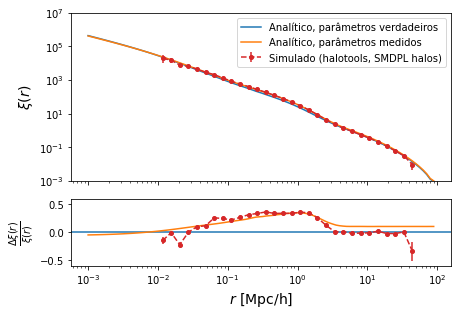

In [19]:
fig = plt.figure(figsize=(6.6, 4.4))

gs = GridSpec(2, 1, height_ratios=[2.5, 1], hspace=0.15)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])


ax = ax1
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-3, 1e7)

l = ax.errorbar(r_synthetic, xi_synthetic, xi_err_synthetic,
                color="tab:red", ls="--", marker='o', ms=4., lw=1.5, label=r"Simulado (halotools, SMDPL halos)")
l = l[0]
ax.plot(r_t, xi_t,
        color="tab:blue", ls="-", lw=1.5, label=r"Analítico, parâmetros verdadeiros")
ax.plot(r_o, xi_o,
        color="tab:orange", ls="-", lw=1.5, label=r"Analítico, parâmetros medidos")


ax.legend(fontsize=10)
ax.set_ylabel(r"$\xi(r)$", fontsize=14);


ax  = ax2

ax.set_xscale("log")
ax.set_ylim(-0.6, 0.6)

l = ax.axhline(0., ls="-", color="tab:blue", lw=1.5)
ax.plot(r_o, rel_dev_xi_true(r_o, xi_o), color="tab:orange", lw=1.5, ls="-")
l = ax.errorbar(r_synthetic, rel_dev_xi_true(r_synthetic, xi_synthetic),
                rel_dev_xi_err_true(r_synthetic, xi_synthetic, xi_err_synthetic),
                ls="dashed", marker="o", ms=4, lw=1.5, color="tab:red")

ax.set_xlabel(r"$r$ [Mpc/h]", fontsize=14)
ax.set_ylabel(r"$\frac{\Delta \xi(r)}{\xi(r)}$", fontsize=14);

ax1.set_xticklabels([])

plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)


fig.savefig(os.path.join(plot_dir, "xi_mcmc_bestfit_true_analitic_models.pdf"), dpi=600)
fig.savefig(os.path.join(plot_dir, "xi_mcmc_bestfit_true_analitic_models.png"), dpi=100)

### Git tags (notebook)

In [13]:
%%bash

for dir in $(find ../code/ -mindepth 1 -maxdepth 1 -type d -printf "%P\n") ;
do
    pushd ../code/$dir > /dev/null
    echo "$dir: $(git rev-parse HEAD)"
    popd > /dev/null
done

pushd $COSMOSIS_SRC_DIR > /dev/null
echo "cosmosis: $(git rev-parse HEAD)"
pushd $COSMOSIS_SRC_DIR/cosmosis-standard-library > /dev/null
echo "cosmosis-standard-library: $(git rev-parse HEAD)"

__pycache__: 824126a38be8ff1b1ed95aab2fb79b59fb40bdec
hod: 5aae026793e6346e22dfde8a4c9889f805c07130
chain-diagnostics: 212f01c17b4226da0c35fe7e5314e17699f8cc94
jackknife-tools: 739c049f37c02820baa255ca11228538c2661291
halotools-utils: 6b22d1d9ea0a87413e46ecff90cea7065e3c6782
hod-scripting-utils: 9cb4ad2c97dc8a881bd9bf84d9392719d3bcaf45
cosmosis: 14abd2e9ae8d01d0623b223a1fc15babd69a2cd9
cosmosis: 14abd2e9ae8d01d0623b223a1fc15babd69a2cd9
cosmosis-standard-library: bbafc5af7de75f152526ef1e8213449a08956884


bash: /home/pedro/miniconda3/envs/monografia/lib/libtinfo.so.6: no version information available (required by bash)
